In [64]:

import numpy as np
import jax.numpy as jnp

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

from pathlib import Path

# PLOTTING
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('spiffy')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mycolorpy import colorlist as mcp

# Local imports
from src.core.activation import SoftReLu

In [65]:
colors_targets = ['#E09F1F', '#907245']
color_fits = ['#00C9B3', '#005B4E']

# 1. Sacramento et al. (2018)

In [66]:
class Sacramento2018Circuit:
    
    g_lk = 0.1      # leak conductance
    g_B = 1.0       # basal dendrite to soma conductance
    g_A = 0.8       # apical dendrite to soma conductance
    g_D = 1.0       # dendritic conductance for interneuron
    sigma = 0.0     # background noise amplitude
    
        
    wXE: float = 1.0    # input -> e weight
    wXI: float = 0.0    # input -> i weight
    wIE: float = - 0.55    # i->e weight
    wEI: float = 1.0    # e->i weight
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
        
    def __init__(self, act) -> None:
        self.act = act

    def vectorfield(self, state, t, x, target = None):    
        ue, ui = state        
                
        # dendritic compartments (instantaneous)
        v_b = self.wXE * x
        v_a = self.wIE * self.act(ui)
        v_inh = self.wEI * self.act(ue)
        
        if target is not None:
            v_a += target
        
        due = - self.g_lk * ue + self.g_B * (v_b - ue) + self.g_A * (v_a - ue) + self.sigma * np.random.randn()
        dui = - self.g_lk * ui + self.g_D * (v_inh - ui) + self.sigma * np.random.randn()
        
        if target is not None:
            dui += target
        
        return np.array([due, dui])
            
    def solve_euler(self, x, target = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            
        return u
    
    def traj_euler(self, x, target = None, u0 = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        us = [u]
        ts = [t]
        
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            us.append(u)
            ts.append(t)
            
        return np.array(ts), np.array(us)
    
    def dw_sacramento(self, x_range, target=None):
        
        state = self.solve_euler(x_range, target=target)
        ue, ui = state
        v_b = self.wXE * x_range
        v_b_hat = v_b * (self.g_B / (self.g_lk + self.g_B + self.g_A))
        
        dw = x_range * (self.act(ue) - self.act(v_b_hat))
        
        return state, dw
    

In [67]:
# PARAMETERS
params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 0.0
}

preact = jnp.linspace(0, 8, 1000)
func = SoftReLu(**params_act)

model = Sacramento2018Circuit(act=func)
model.wXE = np.array([1])

### Panel A: Microcircuit with top-down control

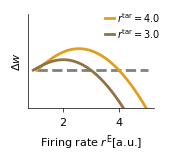

In [68]:
# Input
preact = jnp.linspace(0, 10, 100)

# Targets
target_1 = 4.0
target_2 = 3.0

state_1, dw_1 = model.dw_sacramento(preact, target=target_1)
state_2, dw_2 = model.dw_sacramento(preact, target=target_2)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# First target
uE, uI = state_1
rE = model.act(uE)
rI = model.act(uI)
ax.plot(rE, dw_1, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

# Dashed line
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

# Draw arrow  from below the dashed line pointing upwards that indicates target_1 on the y axis
# Color the arrow in the same color as the line.
#ax.annotate('', xy=(target_1, 0.01), xytext=(target_1, -4),
#            arrowprops=dict(arrowstyle="simple", color=colors_targets[0], lw=0.5))

# Second target
uE, uI = state_2
rE = model.act(uE)
rI = model.act(uI)

ax.plot(rE, dw_2, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])
#ax.annotate('', xy=(target_2, 0.01), xytext=(target_2, -4), 
#            arrowprops=dict(arrowstyle="simple", color=colors_targets[1], lw=0.5))


ax.set_yticks([])
ax.set_ylim(-2, 3)

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')
ax.set_ylabel(r'$\Delta w$')

# Make legend and reduce the spacing between legend and plot border
# also reduce the length of the legend lines
# also reduce vertical spacing between legend entries
ax.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.1, 1.1), frameon=False, borderpad=0.1, handletextpad=0.3, handlelength=1.0, labelspacing=0.2)

plt.show()

### Panel B: Microcircuit without target

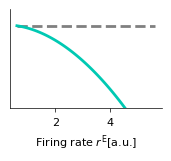

In [69]:
# Input
preact = jnp.linspace(0, 13, 100)

state, dw = model.dw_sacramento(preact, target=None)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

uE, uI = state
rE = model.act(uE)
rI = model.act(uI)
ax.plot(rE, dw, label='dw', lw=2, c=color_fits[0])

# Dashed line
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-10, 2)

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')

plt.show()

### Panel C: Isolated neuron

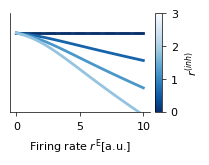

In [70]:
preact = jnp.linspace(0, 10, 100)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# Isolated neuron plasticity (assuming w=1, x the only input and only externally provided inhibition)
list_rI = np.linspace(0.0, 3, 4)
colormap = mcp.gen_color(cmap='Blues_r', n=len(list_rI)+2)
labels = list_rI

# Assume patch clamp is fixing the basal dendritic voltage (i.e. feed-forward input)
v_b = preact
v_b_hat = v_b_hat = v_b * (model.g_B / (model.g_lk + model.g_B + model.g_A))

for rI_idx, rI in enumerate(list_rI):
    
    # apical voltage is equal to inhibitory rate
    v_a = - rI
    
    # Steady-state membrane potential
    ue = (model.g_B * v_b + model.g_A * v_a) / (model.g_lk + model.g_B + model.g_A)
    rE = model.act(ue)
    
    dw = preact * (model.act(ue) - model.act(v_b_hat))
    ax.plot (v_b, dw, label=labels[rI_idx], color=colormap[rI_idx], lw=2)
    
ax.hlines(0, v_b.min(), v_b.max(), lw=2, linestyle='--', color='gray', zorder=0)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=list_rI.min(), vmax=list_rI.max())
cbarMap = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues_r, norm = norm)
fig.colorbar(cbarMap, cax=cax, orientation='vertical')
cax.set_ylabel(r'$r^{(inh)}$')

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$' + '[a.u.]')
#ax.set_ylabel(r'$\Delta w$')

ax.set_yticks([])
ax.set_ylim(-12, 3)

plt.show()

# 2. Meulemans et al. (2021, 2022)

In [71]:
class Meulemans2021Circuit:   
        
    wF: float = 1.0    # input weight
    alpha: float = 1.0 # control strength
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
        
    def __init__(self, act) -> None:
        self.act = act

    def vectorfield(self, u, t, x, target = None):           
                

        du = -u + self.wF * x
        
        if target is not None:
            out = self.act(u)
            error = target - out
            du += self.alpha * error
        
        return du
            
    def solve_euler(self, x, target = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x))])
        
        t = 0
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            
        return u
    
    def traj_euler(self, x, target = None, u0 = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x))])
        
        t = 0
        us = [u]
        ts = [t]
        
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            us.append(u)
            ts.append(t)
            
        return np.array(ts), np.array(us)
    
    def dw_meulemans(self, x_range, target=None):
        v_b = x_range * self.wF
        u = self.solve_euler(x_range, target=target)
        dw = x_range * (u - v_b)
        
        return u, dw

In [72]:
# PARAMETERS
params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 0.0
}

preact = jnp.linspace(0, 8, 1000)
func = SoftReLu(**params_act)

model = Meulemans2021Circuit(act=func)
model.wF = np.array([1])

### Panel A: Top-down control

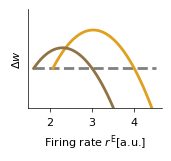

In [73]:
# Input
preact = jnp.linspace(0, 5, 100)

# Targets
target_1 = 4.0
target_2 = 3.0

state_1, dw_1 = model.dw_meulemans(preact, target=target_1)
state_2, dw_2 = model.dw_meulemans(preact, target=target_2)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# First target
u = state_1
rE = model.act(u)
ax.plot(rE[0], dw_1[0], label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

rEmin = rE.min()
rEmax = rE.max()

# Second target
uE = state_2
rE = model.act(uE)

ax.plot(rE[0], dw_2[0], label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])
#ax.annotate('', xy=(target_2, 0.01), xytext=(target_2, -4), 
#            arrowprops=dict(arrowstyle="simple", color=colors_targets[1], lw=0.5))

rEmin = min(rEmin, rE.min())
rEmax = max(rEmax, rE.max())

ax.hlines(0, rEmin, rEmax, lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-2, 3)

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')
ax.set_ylabel(r'$\Delta w$')

plt.show()

### Panel B: Microcircuit without target

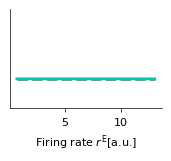

In [74]:
# Input
preact = jnp.linspace(0, 13, 100)

state, dw = model.dw_meulemans(preact, target=None)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

uE = state
rE = model.act(uE)
ax.plot(rE[0], dw[0], label='dw', lw=2, c=color_fits[0])

# Dashed line
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-5, 12)
ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')

plt.show()

### Panel C: Varying levels of inhibition

Because the learning rule computes the difference between basal and somatic potentials, we assume that the patch clamp fixes the basal potential while inhibitory current affects the somatic membrane potential

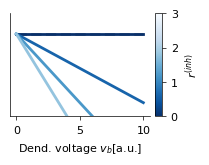

In [75]:
preact = jnp.linspace(0, 10, 100)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# Isolated neuron plasticity (assuming w=1, x the only input and only externally provided inhibition)
list_rI = np.linspace(0.0, 3, 4)
colormap = mcp.gen_color(cmap='Blues_r', n=len(list_rI)+2)
labels = list_rI

# Assume patch clamp is fixing the basal dendritic voltage (i.e. feed-forward input)
v_b = preact

for rI_idx, rI in enumerate(list_rI):
    
    
    # Steady-state membrane potential
    ue = v_b - rI
    rE = model.act(ue)
    
    dw = preact * (ue - v_b)
    ax.plot (v_b, dw, label=labels[rI_idx], color=colormap[rI_idx], lw=2)
    
ax.hlines(0, v_b.min(), v_b.max(), lw=2, linestyle='--', color='gray', zorder=0)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=list_rI.min(), vmax=list_rI.max())
cbarMap = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues_r, norm = norm)
fig.colorbar(cbarMap, cax=cax, orientation='vertical')
cax.set_ylabel(r'$r^{(inh)}$')

ax.set_xlabel(r'Dend. voltage $v_b$' + '[a.u.]')

ax.set_yticks([])
ax.set_ylim(-12, 3)

plt.show()

# 3. Payeur et al. (2021)

In [76]:
class Payeur2021Circuit:
    
    wXE: float = 1.0    # input -> e weight
    alpha: float = 0.0  
    beta: float = 1.0
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
        
    def __init__(self, act) -> None:
        self.act = act
        
        # sigmoid function
        self.sigma = lambda x: 1 / (1 + np.exp(-x))

    def dynamics(self, x, target = None):    
        
        # event rate 
        v = self.wXE * x
        e = self.act(v)
        
        if target is not None:
            error = target - e
            u = error
        else:
            u = 0
            
        # burst probability
        p = self.sigma(self.beta * u + self.alpha)
        
        # burst rate
        b = p * e
        
        return v, e, p, b
    
    def dw_payeur(self, x_range, target=None):
        
        v, e, p, b = self.dynamics(x_range, target)
        
        # steady-state burst rate chosen for zero error 
        p_bar = self.sigma(self.beta * 0 + self.alpha)
        
        dw = x_range * (e * (p - p_bar))
        return e, p, b, dw
    

In [77]:
# PARAMETERS
params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 0.0
}

preact = jnp.linspace(0, 8, 1000)
func = SoftReLu(**params_act)

model = Payeur2021Circuit(act=func)
model.wXE = np.array([1])

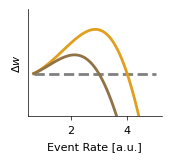

In [78]:
# Input
preact = jnp.linspace(0, 5, 100)

# Targets
target_1 = 4.0
target_2 = 3.0

e1, p1, b1, dw_1 = model.dw_payeur(preact, target=target_1)
e2, p2, b2, dw_2 = model.dw_payeur(preact, target=target_2)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# First target
ax.plot(e1, dw_1, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

rEmin = e1.min()
rEmax = e1.max()


# Second target
ax.plot(e2, dw_2, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])

rEmin = min(rEmin, e2.min())
rEmax = max(rEmax, e2.max())

ax.hlines(0, rEmin, rEmax, lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-2, 3)

ax.set_xlabel('Event Rate '+ '[a.u.]')
ax.set_ylabel(r'$\Delta w$')

plt.show()

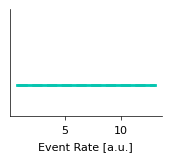

In [79]:
# Input
preact = jnp.linspace(0, 13, 100)

e, p, b, dw = model.dw_payeur(preact, target=None)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))
ax.plot(e, dw, label='dw', lw=2, c=color_fits[0])

# Dashed line
ax.hlines(0, e.min(), e.max(), lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-5, 12)
ax.set_xlabel('Event Rate '+ '[a.u.]')

plt.show()

# 4. Greedy et al. (2022)

In [80]:
class Greedy2022Circuit:
    
    wXE: float = 1.0    # input -> e weight
    wEO: float = 1.0    # e -> output weight
    wY: float = 1.0     # feedback STF (inhibitory) weights
    alpha: float = 4.0  
    beta: float = 0.0
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
        
    def __init__(self, act) -> None:
        self.act = act
        
        # sigmoid function
        self.sigma = lambda x: 1 / (1 + np.exp(-x))
        self.sigma_bar = lambda x: self.sigma(self.alpha * x + self.beta)
        
    def dynamics(self, x, target = None):    
        
        # event rate of hidden layer
        v = self.wXE * x
        e = self.act(v)
        h = self.act.deriv(v) * 1 / e
        
        # event rate & burst probability of output layer
        v_out = self.wEO * e 
        e_out = self.act(v_out)
        h_out = self.act.deriv(v_out) * 1 / e_out
        
        # output error
        if target is not None:
            error = target - e_out
        else:
            error = 0
            
        # requires to invert the error 
        error = -error
        
        # output burst probability
        p_b = self.sigma_bar(0)
        p_out = p_b + p_b * error * h_out
        b_out = e_out * p_out
        
        # apical potential in previous layer
        wQ = p_b * self.wY
        u = wQ * e_out - self.wY * b_out
        
        # burst probabilities
        p = self.sigma_bar(u * h)
        
        return e, p
    
    def dw_greedy(self, x_range, target=None):
        
        e, p = self.dynamics(x_range, target)
        p_b = self.sigma(self.alpha * 0 + self.beta)
        
        dw = x_range * (e * (p - p_b))
        return e, p, dw
    
    def dw_greedy_poissonlike(self, x_range, target=None):
        
        e, p = self.dynamics(x_range, target)
        p_b = self.sigma(self.alpha * 0 + self.beta)
        
        # make p a function of even rate as well as apical p to simulate poisson statistics in the firing rate
        p = 1.6 * (1 - np.exp(-e/10)) * p 
        
        dw = x_range * (e * (p - p_b))
        return e, p, dw
    

In [81]:
# PARAMETERS
params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 0.0
}

preact = jnp.linspace(0, 8, 1000)
func = SoftReLu(**params_act)

model = Greedy2022Circuit(act=func)
model.wXE = np.array([1])

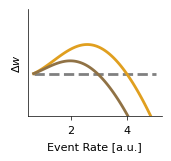

In [82]:
# Input
preact = jnp.linspace(0, 5, 100)

# Targets
target_1 = 4.0
target_2 = 3.0

e1, p1, dw_1 = model.dw_greedy(preact, target=target_1)
e2, p2, dw_2 = model.dw_greedy(preact, target=target_2)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# First target
ax.plot(e1, dw_1, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

rEmin = e1.min()
rEmax = e1.max()


# Second target
ax.plot(e2, dw_2, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])

rEmin = min(rEmin, e2.min())
rEmax = max(rEmax, e2.max())

ax.hlines(0, rEmin, rEmax, lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-2, 3)

ax.set_xlabel('Event Rate '+ '[a.u.]')
ax.set_ylabel(r'$\Delta w$')

plt.show()

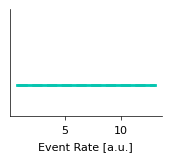

In [83]:
# Input
preact = jnp.linspace(0, 13, 100)

e, p, dw = model.dw_greedy(preact, target=None)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))
ax.plot(e, dw, label='dw', lw=2, c=color_fits[0])

# Dashed line
ax.hlines(0, e.min(), e.max(), lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-5, 12)
ax.set_xlabel('Event Rate '+ '[a.u.]')

plt.show()

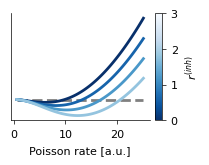

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# Input
preact = jnp.linspace(0, 25, 100)

# Inhibition targeting the apical dendrite would not influence the firing rate at all, but does influence plasticity
list_rI = np.linspace(0, 3, 4)
colormap = mcp.gen_color(cmap='Blues_r', n=len(list_rI)+2)
labels = list_rI

for rI_idx, rI in enumerate(list_rI):
    
    # event rate of hidden layer
    v = model.wXE * preact
    e = model.act(v)
    h = model.act.deriv(v) * 1 / e
    
    # apical input proportional to -rI
    u = -rI
    p = model.sigma_bar(u * h)
    p = 1.6 * (1 - np.exp(-e/10)) * p   # make burst probability a function of the event rate to simulate poisson statistics
    p_b = model.sigma_bar(0)
    
    dw = preact * (e * (p - p_b))
    
    ax.plot(e, dw, label=labels[rI_idx], color=colormap[rI_idx], lw=2)

ax.hlines(0, e.min(), e.max(), lw=2, linestyle='--', color='gray', zorder=0)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=list_rI.min(), vmax=list_rI.max())
cbarMap = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues_r, norm = norm)
fig.colorbar(cbarMap, cax=cax, orientation='vertical')
cax.set_ylabel(r'$r^{(inh)}$')

ax.set_xlabel(r'Poisson rate ' + '[a.u.]')
ax.set_yticks([])

plt.show()